<a href="https://colab.research.google.com/github/cocogne2/projet6/blob/master/projet2_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import tensorflow as tf
import timeit
from google.colab import drive 
from lxml import etree
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
drive.mount('/content/gdrive', force_remount=True)
path_to_data = os.path.join('gdrive','My Drive','projet_6')


Mounted at /content/gdrive


In [8]:
def cpu():
  %matplotlib inline
  path=os.path.join(path_to_data,'Images')
  for folder in os.listdir(path): 
      if os.path.isdir(os.path.join(path,folder)):
          print("folder",folder)
          path2=os.path.join(path,folder)
          race_chien=folder.split("-",1)[1]
          for file in os.listdir(path2):
            file=file.split(".")[0]
            nom_chien=file.split("_")[1]
            print("file:",file)
            tree = etree.parse(os.path.join(path_to_data,'Annotation', folder, file))
            for x in tree.xpath("/annotation/object/bndbox/xmin"):
                x_min=int(x.text)
            for x in tree.xpath("/annotation/object/bndbox/xmax"):
                x_max=int(x.text)
            for y in tree.xpath("/annotation/object/bndbox/ymin"):
                y_min=int(y.text)
            for y in tree.xpath("/annotation/object/bndbox/ymax"):
                y_max=int(y.text)
            
            # Import the image
            
            im = Image.open(os.path.join(path_to_data,'Images', folder, file+".jpg"))
            im=im.crop((x_min,y_min,x_max,y_max))             
            # Create a constant as filename
            file_save=race_chien+"*"+nom_chien

            file_name = os.path.join(path_to_data,'images_crop',file_save+".jpg")
            width, height = im.size
            if width>height:
              new_width=224
              size_index=new_width/width
              new_height=round(height*size_index)
            if width<=height:
              new_height=224
              size_index=new_height/height
              new_width=round(width*size_index)
            im=im.resize((new_width,new_height),Image.ANTIALIAS)
            new_im = Image.new("RGB", (224,224))
            new_im.paste(im, (round((224-new_width)/2),
                                round((224-new_height)/2)))
            new_im.save(file_name)
        
            #print("Image Saved!")
cpu()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
file: n02108551_4341
file: n02108551_3980
file: n02108551_4426
file: n02108551_4379
file: n02108551_3840
file: n02108551_4682
file: n02108551_3814
file: n02108551_4392
file: n02108551_441
file: n02108551_5216
file: n02108551_5682
file: n02108551_572
file: n02108551_5004
file: n02108551_4807
file: n02108551_581
file: n02108551_4927
file: n02108551_4751
file: n02108551_4790
file: n02108551_5547
file: n02108551_5050
file: n02108551_4698
file: n02108551_4820
file: n02108551_4918
file: n02108551_4769
file: n02108551_4697
file: n02108551_5540
file: n02108551_5625
file: n02108551_598
file: n02108551_9132
file: n02108551_6295
file: n02108551_902
file: n02108551_7788
file: n02108551_899
file: n02108551_786
file: n02108551_658
file: n02108551_5830
file: n02108551_734
file: n02108551_640
file: n02108551_6179
file: n02108551_832
file: n02108551_810
file: n02108551_8370
file: n02108551_668
file: n02108551_660
file: n02108

In [10]:
def cpu():
  %matplotlib inline
  path=os.path.join(path_to_data,'Images')
  xx=0
  for folder in os.listdir(path): 
      xx=xx+1
      if os.path.isdir(os.path.join(path,folder)):
          print("folder",folder)
          path2=os.path.join(path,folder)
          race_chien=folder.split("-",1)[1]
          for file in os.listdir(path2):
            file=file.split(".")[0]
            nom_chien=file.split("_")[1]
            print("file:",file)
            tree = etree.parse(os.path.join(path_to_data,'Annotation', folder, file))
            for x in tree.xpath("/annotation/object/bndbox/xmin"):
                x_min=int(x.text)
            for x in tree.xpath("/annotation/object/bndbox/xmax"):
                x_max=int(x.text)
            for y in tree.xpath("/annotation/object/bndbox/ymin"):
                y_min=int(y.text)
            for y in tree.xpath("/annotation/object/bndbox/ymax"):
                y_max=int(y.text)
            
            # Import the image
            
            im = Image.open(os.path.join(path_to_data,'Images', folder, file+".jpg"))
            im=im.crop((x_min,y_min,x_max,y_max))             
            # Create a constant as filename
            file_save=race_chien+"*"+nom_chien

            file_name = os.path.join(path_to_data,'images_crop_20',file_save+".jpg")
            width, height = im.size
            if width>height:
              new_width=224
              size_index=new_width/width
              new_height=round(height*size_index)
            if width<=height:
              new_height=224
              size_index=new_height/height
              new_width=round(width*size_index)
            im=im.resize((new_width,new_height),Image.ANTIALIAS)
            new_im = Image.new("RGB", (224,224))
            new_im.paste(im, (round((224-new_width)/2),
                                round((224-new_height)/2)))
            new_im.save(file_name)
      if xx==20:
         break        
            #print("Image Saved!")
cpu()

folder n02085782-Japanese_spaniel
file: n02085782_1085
file: n02085782_1077
file: n02085782_1059
file: n02085782_1058
file: n02085782_1039
file: n02085782_1191
file: n02085782_1156
file: n02085782_1224
file: n02085782_1143
file: n02085782_1401
file: n02085782_1348
file: n02085782_1267
file: n02085782_1284
file: n02085782_1353
file: n02085782_1350
file: n02085782_1521
file: n02085782_1600
file: n02085782_1503
file: n02085782_1460
file: n02085782_1665
file: n02085782_1434
file: n02085782_17
file: n02085782_1610
file: n02085782_1552
file: n02085782_143
file: n02085782_1691
file: n02085782_1425
file: n02085782_1656
file: n02085782_1528
file: n02085782_1626
file: n02085782_1855
file: n02085782_1774
file: n02085782_1836
file: n02085782_186
file: n02085782_1750
file: n02085782_1778
file: n02085782_1848
file: n02085782_1724
file: n02085782_1731
file: n02085782_172
file: n02085782_1782
file: n02085782_1764
file: n02085782_2014
file: n02085782_2118
file: n02085782_2162
file: n02085782_2074
file:

In [19]:
# ---------------------------------------------------------------------------
# Configuration des paramètres principaux du modèle
# ---------------------------------------------------------------------------
# Le chemin vers la sauvegarde du réseau
model_savepath    = os.path.join(path_to_data,'cnn_vgg16_model_trained_2.h5')     

# Les chemins vers les jeu de données
TRAINING_DIR      = os.path.join(path_to_data,'images_crop_20')
TESTING_DIR       = os.path.join(path_to_data,'test')

IMGSIZE       = 224    # Taille de l'image en input
EPOCH         = 100     # nombre d'epoch 
BATCH_SIZE    = 50     # traitement par batch d'images avant la descente de gradient
FREEZE_LAYERS = 16    # pour un VGG16 freeze de réapprentissage de certaines couches
TRAIN         = True   # Entrainement ou utilisation d'un réseau déjà entrainé

In [20]:
def list_unique(list_unique):
    """
    Cette fonction prend une liste en entrée et retourne la liste sans doublon
    """
    new_list = [] 
    for i in list_unique : 
        if i not in new_list: 
            new_list.append(i) 
    return new_list

In [21]:

# ---------------------------------------------------------------------------
#  Constitution des jeux de données
# ---------------------------------------------------------------------------    

# -------
#  Jeu d'entrainement
# -------

# Dataframe de deux colonnes contenant les id des fichiers et leur label
train_files = os.listdir(TRAINING_DIR)
train_labels = []

for file in train_files:
    train_labels.append(file.split("*",1)[0])
labels_sans_doublon=list_unique(train_labels)
df_train = pd.DataFrame({"id": train_files, "label": train_labels})
print(df_train)

                             id             label
0     Japanese_spaniel*1521.jpg  Japanese_spaniel
1     Japanese_spaniel*2074.jpg  Japanese_spaniel
2     Japanese_spaniel*2655.jpg  Japanese_spaniel
3      Japanese_spaniel*230.jpg  Japanese_spaniel
4     Japanese_spaniel*3578.jpg  Japanese_spaniel
...                         ...               ...
3628        Maltese_dog*233.jpg       Maltese_dog
3629      Maltese_dog*22666.jpg       Maltese_dog
3630      Maltese_dog*20610.jpg       Maltese_dog
3631      Maltese_dog*25908.jpg       Maltese_dog
3632       Maltese_dog*3677.jpg       Maltese_dog

[3633 rows x 2 columns]


In [22]:
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
#from keras.optimizers import adam_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [23]:

# Image generator: attention il est préférable de ne pas utiliser d'augmentation de données
# Nous utilisons également un processing spécifique au VGG16 et non pas un rescale 1./255
train_datagen =  \
        ImageDataGenerator(
            preprocessing_function=preprocess_input,
            validation_split=0.20)

train_generator = \
        train_datagen.flow_from_dataframe(
            df_train,
            TRAINING_DIR,
            x_col='id',
            y_col='label',
            shuffle=True,
            target_size=(IMGSIZE, IMGSIZE),
            batch_size=BATCH_SIZE,
            subset='training',
            class_mode='categorical')
train_labels = to_categorical(train_generator.classes)

Found 2907 validated image filenames belonging to 20 classes.


In [24]:
# -------
#  Jeu de validation
# -------

valid_generator = \
        train_datagen.flow_from_dataframe(
            df_train,
            TRAINING_DIR,
            x_col='id',
            y_col='label',
            shuffle=True,
            target_size=(IMGSIZE, IMGSIZE),
            batch_size=BATCH_SIZE,
            subset='validation',
            class_mode='categorical')



Found 726 validated image filenames belonging to 20 classes.


In [25]:
# -------
# Jeu de test
# -------

test_files = os.listdir(TESTING_DIR)
print(test_files)
df_test = pd.DataFrame({"id": test_files, 'label': 'nan'})
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = \
    test_datagen.flow_from_dataframe(
        df_test, 
        TESTING_DIR, 
        x_col='id',
        y_col=None, 
        target_size=(IMGSIZE, IMGSIZE), 
        class_mode=None, 
        seed=42,
        batch_size=1, 
        shuffle=False
    )

['2norwich_terrier.jpg']
Found 1 validated image filenames.


In [26]:
# -----------
# VGG16 pre-entrainé sans le classifier final
# https://github.com/keras-team/keras/issues/4465
# -----------

# Déclaration du modèle VGG16 (sans le top qui est le classifier)

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMGSIZE, IMGSIZE, 3))


In [27]:
# Classifier
x = base_model.output
x = Flatten(name="flatten")(x)
x = Dropout(0.5)(x)
x = Dense(20, activation='relu', name='top-fc1')(x)
x = Dense(20, activation='relu', name='top-fc2')(x)
#x = Dropout(0.2)(x)

# output layer: nombre de neurones de sortie = nombre de classe a prédire
output_layer = Dense(len(labels_sans_doublon),activation='softmax', name='softmax')(x)

In [28]:

# Assemblage du modèle final
net_final = Model(inputs=base_model.input, outputs=output_layer)

for layer in base_model.layers:
    layer.trainable = False

# freeze de certains layers (spécifique au modèle utilisé)
#for layer in net_final.layers[:FREEZE_LAYERS+]:
#    layer.trainable = False
    
# Entrainement des derniers layers de classification
#for layer in net_final.layers[FREEZE_LAYERS:]:
#    layer.trainable = True

# compilation du modele
net_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(net_final.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [29]:
# Génération des STEPS_SIZE (comme nous utilisons des générateurs infinis)
# Ceci est nécessaire pour déterminer à quel moment nous avons parcouru entiérement nos jeu de données
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST  = test_generator.n  // test_generator.batch_size

In [30]:
pip install livelossplot

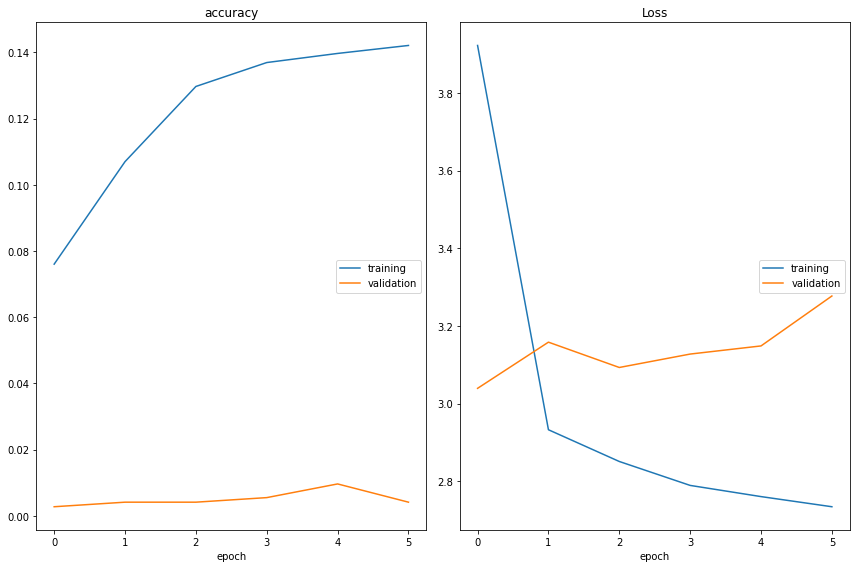

accuracy
	training         	 (min:    0.076, max:    0.142, cur:    0.142)
	validation       	 (min:    0.003, max:    0.010, cur:    0.004)
Loss
	training         	 (min:    2.734, max:    3.922, cur:    2.734)
	validation       	 (min:    3.039, max:    3.277, cur:    3.277)


In [31]:
from livelossplot.inputs.keras import PlotLossesCallback
if (TRAIN):
    plot_loss_1 = PlotLossesCallback()

    # Création des Callbacks à appeler aprés chaque epoch
    #   pour sauvegarde des résultats
    checkpoint = ModelCheckpoint("model_1.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
    #   pour arrêt prématuré
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    
#   history = net_final.fit(train_generator,steps_per_epoch = STEP_SIZE_TRAIN, epochs=EPOCH, validation_data=valid_generator,validation_steps = STEP_SIZE_VALID,callbacks = [checkpoint, early, plot_loss_1])
    history = net_final.fit(train_generator, epochs=EPOCH, validation_data=valid_generator,batch_size=BATCH_SIZE,callbacks = [checkpoint, early, plot_loss_1])
    # Sauvegarde du réseau après entrainement
    net_final.save(model_savepath)    
    

In [ ]:
from tensorflow import keras
net_final = keras.models.load_model(model_savepath)


In [ ]:
# Evaluation du modèle
(eval_loss, eval_accuracy) = net_final.evaluate(valid_generator, steps=STEP_SIZE_TEST)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

6/6 [==============================] - 48s 8s/step - loss: 10.8675 - accuracy: 0.0000e+00
[INFO] accuracy: 0.00%
[INFO] Loss: 10.867462158203125


In [ ]:
# Affichage des classes du jeu d'entrainement
train_generator.class_indices
# Génération des prédictions
test_generator.reset()
pred = net_final.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)
# La colonne 1 représente la probabilité que l'image soit un chien (la colonne 0 que l'image soit un chat)
print(pred)
# find the index of the class with maximum score
pred2 = np.argmax(pred, axis=1)
print("peed2",pred2)

print(labels_sans_doublon[pred2[0]])
from keras.applications.vgg16 import decode_predictions

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(pred, top=3)[0])

1/1 [==============================] - 1s 623ms/step
[[1.43625550e-02 4.11738074e-05 1.19223176e-02 1.09637165e-02
  9.40471515e-03 1.25277173e-02 1.11699114e-02 1.29996380e-02
  1.15642380e-02 9.11638327e-03 1.06011070e-02 1.12458812e-02
  8.86365119e-03 1.79031158e-05 9.08497628e-03 1.56204405e-05
  1.03710992e-02 9.12594516e-03 1.07741375e-02 8.66069738e-03
  9.15401895e-03 9.14899260e-03 9.47552547e-03 1.20816501e-02
  9.49352048e-03 8.50914326e-03 8.69873166e-03 9.76217352e-03
  9.39162355e-03 9.55463480e-03 1.21389148e-05 9.72090103e-03
  1.14494711e-02 9.47479345e-03 9.71085671e-03 8.97469372e-03
  1.25002870e-02 1.05291642e-02 1.06846876e-02 1.15037542e-02
  1.02606555e-02 1.16474880e-02 1.35897872e-05 1.13010909e-02
  1.46168163e-02 1.00836933e-05 1.80220359e-05 1.03846528e-02
  1.23834964e-02 1.28551442e-02 1.05320355e-02 9.00514144e-03
  2.96180533e-05 8.98177768e-06 1.05618611e-02 9.32666566e-03
  1.03701456e-02 1.20656835e-02 1.03001003e-05 9.49750748e-03
  1.33645516e-02 

ValueError: ignored